In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
dataset_root = "BookCrossing_data"
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv(dataset_root+'/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1', low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv(dataset_root+'/BX-Books.csv', sep=';', names=i_cols, encoding='latin-1', low_memory=False, on_bad_lines='warn')

#Ratings, rating of 0 if a user has not rated a book.
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv(dataset_root+'/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1', low_memory=False)


Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9
Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9
Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9
Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10



In [6]:
# get rid of column titles
users = users.drop(users.index[0])
items = items.drop(items.index[0])
ratings = ratings.drop(ratings.index[0])
# convert fields to certain types
users['age'] = users['age'].astype(float)
users['user_id'] = users['user_id'].astype(int)
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(int)
ratings['isbn'] = ratings['isbn'].astype(str)
#items['year_of_publication'] = items['year_of_publication'].astype(int)
items['isbn'] = items['isbn'].astype(str)

In [7]:
# get rid of implicit ratings
ratings = ratings.loc[ratings['rating'] > 0]
# get rid of users that gave less than <threshold> ratings
rating_threshold = 10
counts = ratings['user_id'].value_counts()
users_to_remove = counts[counts < rating_threshold].index.tolist()
ratings = ratings[~ratings['user_id'].isin(users_to_remove)]
users = users[users['user_id'].isin(ratings['user_id'])]

In [8]:
# get rid of books that have less than <threshold> ratings, not sure yet if ratings for the same book must come from different users yet
book_threshold = 20

counts = ratings['isbn'].value_counts()
books_to_remove = counts[counts < book_threshold].index.tolist()
items = items[~items['isbn'].isin(books_to_remove)]

items.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
5,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
9,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...
10,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...
11,0771074670,Nights Below Station Street,David Adams Richards,1988,Emblem Editions,http://images.amazon.com/images/P/0771074670.0...,http://images.amazon.com/images/P/0771074670.0...,http://images.amazon.com/images/P/0771074670.0...


In [9]:
def calc_MSE(u1: str, u2: str) -> int:
    '''
        Return mean squared error between the shared ratings of two given users. Adds 1 to the actual MSE to avoid edge weights of 0 which mess with the graph
    '''
    u1_ratings = ratings[ratings['user_id'] == u1]
    u2_ratings = ratings[ratings['user_id'] == u2]
    intersect = pd.merge(u1_ratings, u2_ratings, how='inner', on=['isbn'])
    return ((intersect['rating_x'] - intersect['rating_y']) ** 2).sum() / len(intersect) + 1


# user-user graph has connection between users with weight based on how similar their ratings are
def create_graph(start, end, min_shared_ratings, include_leafs=True):
    G = nx.Graph()
    user_list = users["user_id"].tolist()
    for i, user in enumerate(user_list[start: end]):
        if i % 1000 == 0:
            print(str(i) + "/" + str(end) + " users iterated over")
        user_ratings = ratings[ratings['user_id'] == user]
        # get counts for how many shared ratings each user has with the current user
        shared_rating_counts = ratings[ratings['isbn'].isin(user_ratings['isbn'])]['user_id'].value_counts()
        # users with at least (min_shared_ratings) number of ratings shared between them and the current user
        neighbors = shared_rating_counts[shared_rating_counts >= min_shared_ratings].index.tolist()
        G.add_weighted_edges_from([(user, neighbor, calc_MSE(user, neighbor)) for neighbor in neighbors if user != neighbor])

    if include_leafs:
        return G
    else:
        # only include nodes with more than one edge
        return G.subgraph([n for n, d in G.degree() if d >= 2])



In [10]:
from matplotlib.colors import Normalize
import math

def edge_color(g, u, v, norm, vmax):
    if g[u][v]['weight'] == math.inf:
        return plt.cm.Reds(norm(vmax))
    else:
        return plt.cm.Reds(norm(g[u][v]['weight']))

def drawGraphGradient(graph, node_labels=False, edge_labels=False, vmin=1, vmax=10):
    norm = Normalize(vmin, vmax)
    pos = nx.spring_layout(graph)

    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='#FF0000')
    nx.draw_networkx_edges(graph, pos, edge_color=[edge_color(graph, u, v, norm, vmax) for u, v in graph.edges()], width=5)
    if node_labels:
        nx.draw_networkx_labels(graph, pos)
    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'weight'))
    plt.axis('off')
    plt.show()

# graph = create_graph(start=0, end=1_000, min_shared_ratings=25, include_leafs=False)
# drawGraphGradient(graph)



Now that I know that my database -> graph function works, I want to make a graph using the full database (still under the constraints listed above). This will take a long time and I don't want to have to redo the processing of the database every single time, so I will store the graph object locally using pickle

In [11]:
import pickle

# large_graph = create_graph(0, users['user_id'].size, 30, include_leafs=True)
# with open('30_shared_recs_graph.pickle', 'wb') as f:
#     pickle.dump(large_graph, f)

In [12]:
# other_graph = create_graph(0, users['user_id'].size, 20, include_leafs=True)
# with open('20_shared_recs_graph.pickle', 'wb') as f:
#     pickle.dump(other_graph, f)

In [13]:
# last_graph = create_graph(0, users['user_id'].size, 10, include_leafs=True)
# with open('10_shared_recs_graph.pickle', 'wb') as f:
#     pickle.dump(last_graph, f)

Below is the serendipity algorithm run on an example graph

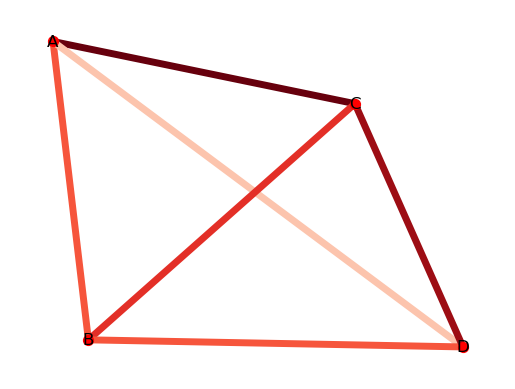

In [22]:
example_graph = nx.Graph()
example_graph.add_nodes_from(['A', 'B', 'C', 'D'])
example_graph.add_weighted_edges_from([('A', 'B', 6), ('A', 'C', 10), ('C', 'B', 7), ('C', 'D', 9), ('D', 'B', 6), ('A', 'D', 3)])
drawGraphGradient(example_graph, node_labels=True)

In [15]:
# want to relate path to the serendipity node and path from that node to the other neighbor
# minimize inverse path cost -> 1 / (difference between edge cost and starting cost)
# also if you only allow it to use 1 / x thing for other nodes, then it will never pick that edge anyway
# only works when the denominator is difference between other edge and this edge
# this is maximizing the difference between the starting edge and the paths edges, can also set a cutoff for path length
# also should have a constraint that an edge used in path cannot be larger than the bottleneck
# once you have a list of the nodes, return the most popular books from the top k of those nodes

def dfs_edges_helper(graph: nx.Graph, sourceNode: str, depth_limit: int, differenceWeight: int):
    '''
        Returns list of all edges reachable from searchNode, along with a new weight according to my algorithm
    '''
    if depth_limit <= 0:
        return []
    
    result = []
    for neighbor in graph.neighbors(sourceNode):
        if 'explored' not in graph.edges[(sourceNode, neighbor)] or not graph.edges[(sourceNode, neighbor)]['explored']:
            graph.edges[(sourceNode, neighbor)]['explored'] = True
            newWeight = differenceWeight - graph.edges[(sourceNode, neighbor)]['weight']
            if newWeight > 0:
                newWeight = 1 / newWeight
            else:
                # prevents division by 0, and also prevents us from choosing path with an edge that is worse than the neighbor edge we are trying to overcome
                newWeight = 100

            result.append( (sourceNode, neighbor, newWeight) )
            result += dfs_edges_helper(graph, neighbor, depth_limit-1, differenceWeight)


    return result



def get_difference_subgraph(graph: nx.Graph, sourceNode: str, depth_limit: int, differenceWeight: int):
    assert sourceNode in graph.nodes
    
    edges = dfs_edges_helper(graph.copy(), sourceNode, depth_limit, differenceWeight)
    newGraph = nx.Graph()
    newGraph.add_weighted_edges_from(edges)
    return newGraph


# TODO: mode is not working, I need it to actually return the mode among given user ratings
def find_reccomendation(queryUser: str, similar_users: list[str], min_rating=8):
    '''
        Returns isbn of book my algorithm reccomends, based on the mode of the similar_users input. If similar_users has multiple
        users in each element, then we need to just treat all of those users the same
    '''
    print('Making reccomendation based on ' + str(len(similar_users)) + " input similar users...")

    # concatenate the ratings of input users
    concatenated_ratings = pd.concat([ratings[ratings['user_id'] == user] for user in similar_users])
    # take out ratings with less than min_rating score
    concatenated_ratings = concatenated_ratings[concatenated_ratings['rating'] >= min_rating]
    # take out any books that the query user has already read (based on whether they rated it)
    concatenated_ratings = concatenated_ratings[~concatenated_ratings['isbn'].isin(ratings[ratings['user_id'] == queryUser]['isbn'])]
    if len(similar_users) > 1:
        return concatenated_ratings['isbn'].mode()
    else:
        return concatenated_ratings



def make_reccomendation(graph: nx.Graph, queryNode: str, search_depth: int, min_rating: int, num_paths=2):
    # Will hold list of ([nodes in serendipity path to neighbor], total serendipity cost of said path)
    serendipity_nodes = []
    
    for neighbor in graph.neighbors(queryNode):
        costToNeighbor = graph.edges[(queryNode, neighbor)]['weight']
        # gets graph with nodes that are reachable from the neighbor with search_depth number of edges
        differenceSubgraph = get_difference_subgraph(graph, neighbor, search_depth, costToNeighbor)
        distance, shortest_path = nx.single_source_dijkstra(differenceSubgraph, source=queryNode, target=neighbor)
        # we only want to include paths that do not have edges with a greater difference in it than there is between queryNode and neighbor, otherwise that edge is useless
        if distance < 100 and len(shortest_path) > 2:
            serendipity_nodes.append((shortest_path[1:-1], distance))

    best_user_paths = sorted(serendipity_nodes, key = lambda x : x[1])[: min(len(serendipity_nodes), num_paths)]
    # unpack the list so that we have just the users left over
    best_users = []
    for userList, _ in best_user_paths:
        for user in userList:
            best_users.append(user)
    
    return find_reccomendation(queryNode, best_users, min_rating=min_rating)

In [16]:
ratings.head()

,user_id,isbn,rating
134,276822,0060096195,10
135,276822,0141310340,9
136,276822,0142302198,10
137,276822,0156006065,9
138,276822,0375821813,9


Now that the algorithm is done, we can test it on an example user.

In [17]:
ten_shared_recs = last_graph
user_ids = [id for id in ten_shared_recs.nodes if len(ten_shared_recs[id].keys()) > 1]
print("Number of users: ", len(user_ids))
queryUserId = user_ids[2]
queryUser = users[users['user_id'] == queryUserId]
queryUser

NameError: name 'last_graph' is not defined

In [ ]:
def get_books(isbn: list[str]):
    return items[items['isbn'].isin(isbn)]

items[items['isbn'].isin(ratings[ratings['user_id'] == queryUserId]['isbn'])]

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
49,042518630X,Purity in Death,J.D. Robb,2002,Berkley Publishing Group,http://images.amazon.com/images/P/042518630X.0...,http://images.amazon.com/images/P/042518630X.0...,http://images.amazon.com/images/P/042518630X.0...
205,0316602906,The Big Bad Wolf: A Novel,James Patterson,2003,"Little, Brown",http://images.amazon.com/images/P/0316602906.0...,http://images.amazon.com/images/P/0316602906.0...,http://images.amazon.com/images/P/0316602906.0...
206,0316693006,Four Blind Mice,James Patterson,2002,"Little, Brown",http://images.amazon.com/images/P/0316693006.0...,http://images.amazon.com/images/P/0316693006.0...,http://images.amazon.com/images/P/0316693006.0...
219,0385497466,The Brethren,JOHN GRISHAM,2000,Doubleday,http://images.amazon.com/images/P/0385497466.0...,http://images.amazon.com/images/P/0385497466.0...,http://images.amazon.com/images/P/0385497466.0...
222,0385511612,Bleachers,John Grisham,2003,Doubleday,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...
...,...,...,...,...,...,...,...,...
23060,0373244487,Cordina's Crown Jewel,Nora Roberts,2002,Silhouette,http://images.amazon.com/images/P/0373244487.0...,http://images.amazon.com/images/P/0373244487.0...,http://images.amazon.com/images/P/0373244487.0...
24365,0064400042,On the Banks of Plum Creek,Laura Ingalls Wilder,1953,HarperTrophy,http://images.amazon.com/images/P/0064400042.0...,http://images.amazon.com/images/P/0064400042.0...,http://images.amazon.com/images/P/0064400042.0...
25782,0312971125,Crazy for You,Jennifer Crusie,2000,St. Martin's Press,http://images.amazon.com/images/P/0312971125.0...,http://images.amazon.com/images/P/0312971125.0...,http://images.amazon.com/images/P/0312971125.0...
27550,0446527033,The Switch,Sandra Brown,2000,Warner Books,http://images.amazon.com/images/P/0446527033.0...,http://images.amazon.com/images/P/0446527033.0...,http://images.amazon.com/images/P/0446527033.0...


Now we can first try running a simple knn search on my graph, just finding the neighbors that have a MSE less than a certain threshold than finding the mode of those users' books

In [ ]:
similarUsers = []
MSE_threshold = 10

for neighbor in ten_shared_recs.neighbors(queryUserId):
    if ten_shared_recs[queryUserId][neighbor]['weight'] <= MSE_threshold:
        similarUsers.append(neighbor)

print('Number of similar users: ', len(similarUsers))
reccomendations = find_reccomendation(queryUser=queryUserId, similar_users=similarUsers, min_rating=7)
get_books(reccomendations)

Number of similar users:  38
Making reccomendation based on 38 input similar users...


,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
1864,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...


In [ ]:
reccomendations = make_reccomendation(ten_shared_recs, queryUserId, search_depth=4, num_paths=30, min_rating=7)
get_books(reccomendations)

Making reccomendation based on 38 input similar users...


,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
17678,0515122734,Sanctuary,Nora Roberts,2004,Jove Books,http://images.amazon.com/images/P/0515122734.0...,http://images.amazon.com/images/P/0515122734.0...,http://images.amazon.com/images/P/0515122734.0...
